In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM
import copy


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [8]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_trainrepeat.npy')
dec_trainrepeat = np.load(save_filename, allow_pickle=True).item()
dec_trainrepeat.keys()
dec_trainrepeat['acc_bytask'].shape

(7, 8, 3)

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
dec_withintask['acc_bytask'].shape

(7, 8, 4)

In [14]:
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [20]:
trn_type_colors = cm.RdPu(np.linspace(0,1,6))[2:4,:]
trn_type_names = ['Within Task','Train Repeat']

In [21]:
acc = np.concatenate([dec_trainrepeat['acc_bytask'][:,:,:,None], \
                      dec_withintask['acc_bytask'][:,:,0:3,None]], axis=3)
acc.shape

(7, 8, 3, 2)

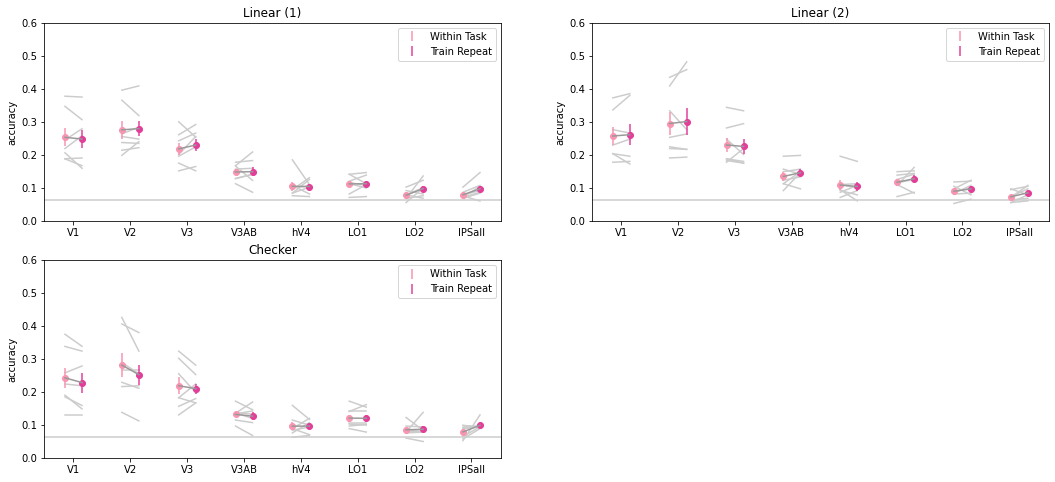

In [22]:
plt.figure(figsize=(18,8))

ti_plot = [0,1,2]

x_jitter = np.linspace(-0.15, 0.15, 2)

for ti in ti_plot:
    
    plt.subplot(2,2,ti+1)
    plt.axhline(1/16, color=[0.8, 0.8, 0.8])

    lh = []

    for xi in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[xi]

        vals = acc[:,:,ti,xi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

        plt.plot(x_ticks, meanvals, 'o', color=trn_type_colors[xi])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, \
                         color=trn_type_colors[xi], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):

        meanvals = np.mean(acc[:,ri,ti,:], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, acc[:,ri,ti,:].T, color=[0.8, 0.8, 0.8], zorder=-10)


    plt.ylim([0, 0.6])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,trn_type_names)

    plt.title('%s'%(task_names[ti]))
    